In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud #For text data visualiztion
import preprocess_kgptalkie as ps

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Conv1D,MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score

In [3]:
fake=pd.read_csv('fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [5]:
fake['subject'].value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

<Axes: xlabel='subject', ylabel='count'>

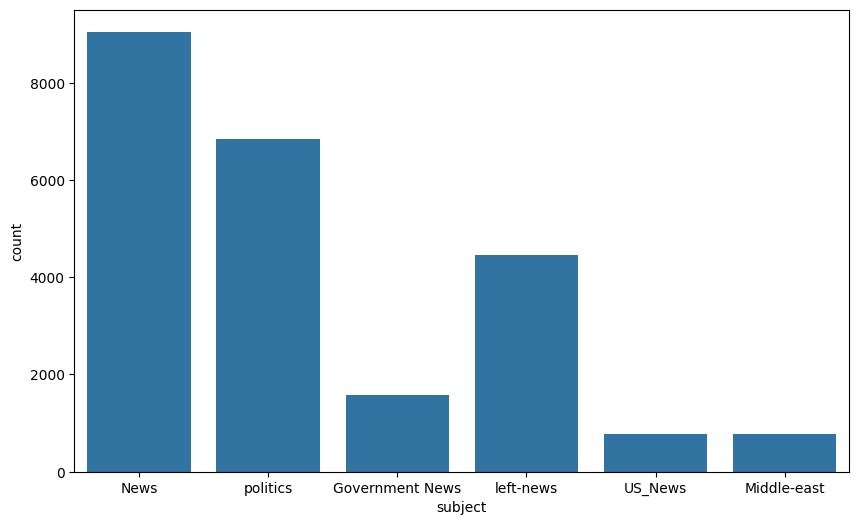

In [6]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=fake)

In [7]:
#wordcloud is for text data visualization
#before that make fake text to a single list 
#fake['text']
fake['text'].tolist()
#to feed data to wordcloud we need single text data.so convert list to text using join
text=' '.join(fake['text'].tolist())

In [8]:
' '.join(['this','is','a','data'])

'this is a data'

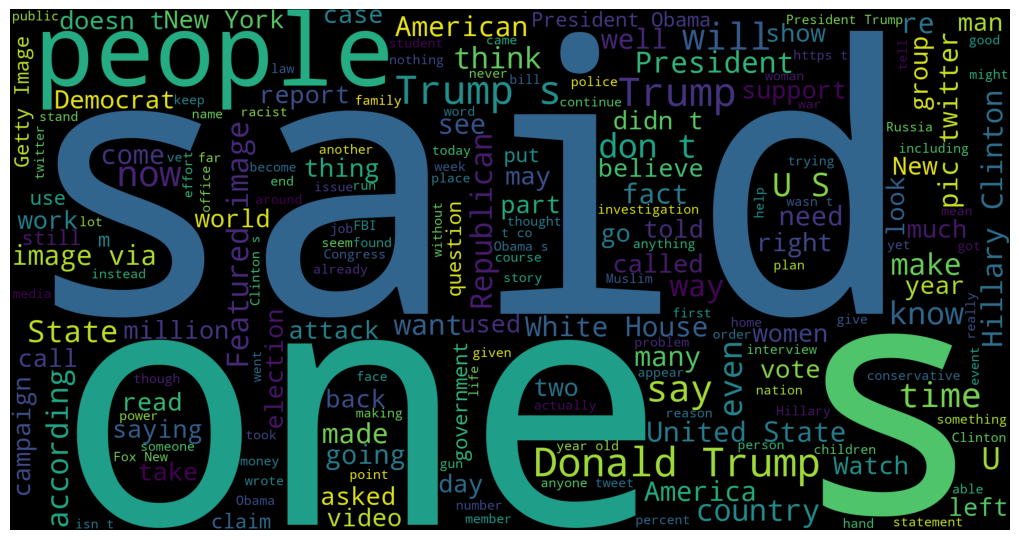

In [9]:
wordcloud=WordCloud(width=1920,height=1000).generate(text)
fig=plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [10]:
real=pd.read_csv('true.csv')

In [11]:
text=' '.join(real['text'].tolist())

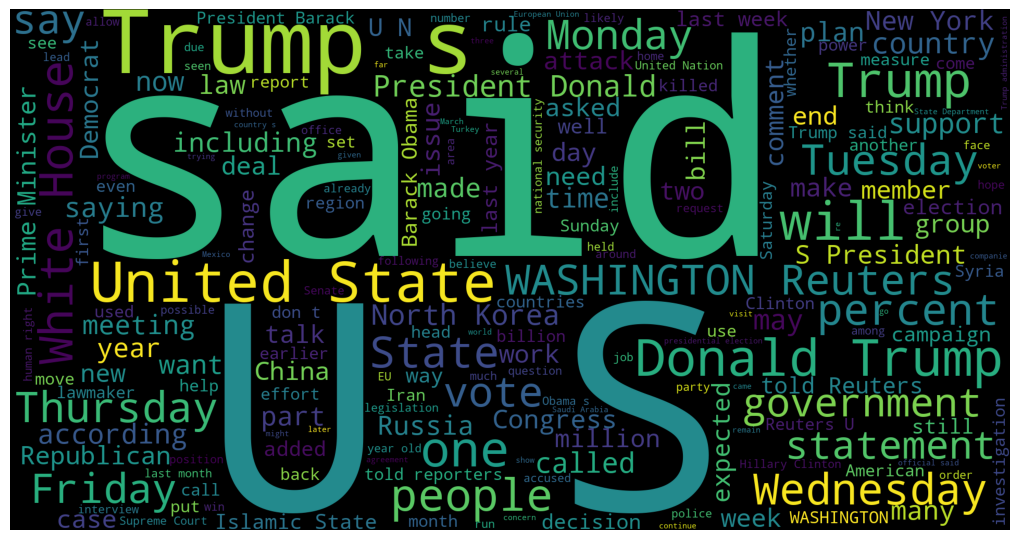

In [12]:
wordcloud=WordCloud(width=1920,height=1000).generate(text)
fig=plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Cleaning data

In [13]:
real.sample(5)

,title,text,subject,date
8752,"In Virginia, Clinton tests Senator Tim Kaine a...","WASHINGTON/ANNANDALE, Virginia (Reuters) - Hil...",politicsNews,"July 14, 2016"
17804,Eurogroup head Dijsselbloem to leave Dutch pol...,AMSTERDAM (Reuters) - Outgoing Dutch Finance M...,worldnews,"October 11, 2017"
16653,Indonesia passes law to ban organizations deem...,"JAKARTA (Reuters) - Around 1,000 Indonesians, ...",worldnews,"October 24, 2017"
13559,EU considers new plan to ease disputes over mi...,BRUSSELS (Reuters) - EU governments will study...,worldnews,"November 29, 2017"
9746,White House says Biden's visit is a good indic...,WASHINGTON (Reuters) - The White House on Thur...,politicsNews,"April 28, 2016"


In [14]:
unknown_publishers=[]
for index,row in enumerate(real.text.values):
    try:
        record=row.split('-',maxsplit=1)
        record[1]
        assert(len(record[0])<120)
    except:
        unknown_publishers.append(index)

In [15]:
len(unknown_publishers)

222

In [16]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [17]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [18]:
publisher=[]
temp_text=[]

for index,row in enumerate(real.text.values):
    if index   in unknown_publishers:
        temp_text.append(row)
        publisher.append('Unknown')

    else:
        record=row.split('-',maxsplit=1)
        publisher.append(record[0].strip())
        temp_text.append(record[1].strip())

In [19]:
real['publisher']=publisher
real['text']=temp_text

real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [20]:
real.shape

(21417, 5)

In [21]:
#Check if fake news has empty text data and find its indexas real which we done before
empty_fake_index=[index for index,text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [22]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [23]:
#text of above are present in the title itself so merge title and text data together

real['text'] = real['title']+" "+real['text']
fake['text'] = fake['title']+" "+fake['text']

In [24]:
#convert Upper case to Lower case of text
real['text']=real['text'].apply(lambda x:str(x).lower())
fake['text']=fake['text'].apply(lambda x:str(x).lower())

PREPROCESSING

In [25]:
real['class']=1
fake['class']=0

In [26]:
#Now we want only text and class
real=real[['text','class']]
fake=fake[['text','class']]

In [27]:
#Append fake and real together
data = pd.concat([real, fake], ignore_index=True)
data.sample(5)

,text,class
7686,clinton expresses concern about at&t-time warn...,1
19160,"kurds stick with independence vote, 'never goi...",1
43930,‘stranger things’ – hollywood mk ultra goes fu...,0
610,u.s. congress to seek new tax incentives for p...,1
767,new york mayor de blasio wins re-election in w...,1


In [28]:
import preprocess_kgptalkie as ps

In [29]:
#Removes all the special characters
data['text']=data['text'].apply(lambda x: ps.remove_special_chars(x))

In [31]:
import gensim
from gensim.models import Word2Vec

In [32]:
y=data['class'].values

In [33]:
#text data convert to sequence of list and this list convert to list of list
X=[d.split() for d in data['text'].tolist()]
print(X[0])


['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [34]:
DIM = 100 #Each of the word convert to sequence of 100 vectors
w2v_model=gensim.models.Word2Vec(sentences=X,vector_size=100,window=10,min_count=1)

In [35]:
len(w2v_model.wv.key_to_index)

230893

In [36]:
#vectors which we converted
w2v_model.wv['india']


array([-2.3672493 ,  1.3566856 , -2.144586  ,  3.7250116 ,  0.40678537,
       -1.679183  ,  0.4831809 ,  0.45325375, -2.5198007 ,  2.1111531 ,
        0.7649543 , -0.71071064, -1.5566199 , -0.7164607 ,  2.740554  ,
        1.5122924 ,  0.6305355 ,  0.2894615 ,  0.0241582 , -0.11508742,
        1.5999697 ,  0.07825938,  0.11613925,  0.6477017 ,  0.56883335,
        0.80547917,  2.0895267 ,  1.19449   , -1.2137086 ,  1.1470555 ,
        3.0501208 ,  0.7410432 , -1.7969128 ,  1.1524533 , -0.6439825 ,
        0.537244  , -2.1114442 , -2.0411637 ,  2.628324  ,  2.1686304 ,
        1.0086014 , -4.4486666 ,  0.7317978 ,  1.1766988 , -1.6799412 ,
        1.5415633 ,  0.5105225 ,  3.4838407 , -2.130934  ,  0.43342027,
        0.5158881 , -2.5899198 ,  0.6675279 , -0.2580018 , -1.920677  ,
       -2.811501  , -0.20030299,  1.1884215 ,  1.1539948 , -1.9828799 ,
       -1.2592199 ,  0.08353445, -0.8588454 ,  1.1335288 ,  1.4761006 ,
        0.99252725, -0.27197024,  0.10546993,  2.6409347 , -0.57

In [37]:
#most similar word to given word
w2v_model.wv.most_similar('india')

[('pakistan', 0.7174482941627502),
 ('malaysia', 0.7012078166007996),
 ('modi', 0.6532444953918457),
 ('australia', 0.6333901286125183),
 ('indias', 0.6168537139892578),
 ('china', 0.6086724400520325),
 ('singapore', 0.604346513748169),
 ('indian', 0.6039980053901672),
 ('narendra', 0.594248354434967),
 ('thailand', 0.5936409831047058)]

In [ ]:
#There are two methods to train ML model one by directly using these vectors and other bu
#by feeding these as initial weight to ml model and then model recreates these vectors
#Second method will give better accuracy

tokenizer=Tokenizer()
tokenizer.fit_on_texts(X)
#X now converted to a set of sequence from text

In [39]:
X=tokenizer.texts_to_sequences(X)


In [42]:
#For particuar word sequence number is assigned
#tokenizer.word_index

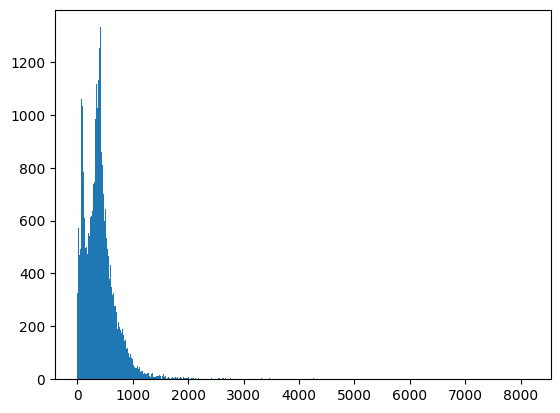

In [44]:
plt.hist([len(x) for x in X],bins=700)
plt.show()

In [46]:
nos=np.array([len(x) for x in X])
len(nos[nos>1000])
#no of news with more than 1000 words

1587

In [47]:
 #now truncate it
maxlen=1000
X=pad_sequences(X,maxlen=maxlen)
#we have every sequence with max len of 1000

In [54]:
vocab_size=len(tokenizer.word_index)+1
vocab=tokenizer.word_index

In [55]:
def get_weight_matrix(model):
    weight_matrix=np.zeros((vocab_size,DIM))

    for word, i in vocab.items():
        weight_matrix[i]=model.wv[word]

    return weight_matrix

In [57]:
embedding_vectors=get_weight_matrix(w2v_model)
embedding_vectors.shape

(230894, 100)

In [61]:
#now create model

model=Sequential()
model.add(Embedding(vocab_size,output_dim=DIM,weights=[embedding_vectors],input_length=maxlen,trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

c:\Users\bonth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [63]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │    23,089,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,089,400 (88.08 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,089,400 (88.08 MB)

In [65]:
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [66]:
model.fit(X_train,y_train,validation_split=0.3,epochs=6)

Epoch 1/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 277s 373ms/step - acc: 0.9193 - loss: 0.1989 - val_acc: 0.9599 - val_loss: 0.1152
Epoch 2/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 415s 563ms/step - acc: 0.9729 - loss: 0.0785 - val_acc: 0.9773 - val_loss: 0.0669
Epoch 3/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 484s 656ms/step - acc: 0.9867 - loss: 0.0410 - val_acc: 0.9912 - val_loss: 0.0311
Epoch 4/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 419s 568ms/step - acc: 0.9949 - loss: 0.0159 - val_acc: 0.9894 - val_loss: 0.0301
Epoch 5/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 473s 642ms/step - acc: 0.9943 - loss: 0.0209 - val_acc: 0.9939 - val_loss: 0.0217
Epoch 6/6
737/737 ━━━━━━━━━━━━━━━━━━━━ 503s 683ms/step - acc: 0.9987 - loss: 0.0054 - val_acc: 0.9939 - val_loss: 0.0188


In [67]:
y_pred=(model.predict(X_test)>=0.5).astype(int)

351/351 ━━━━━━━━━━━━━━━━━━━━ 76s 214ms/step


In [68]:
accuracy_score(y_test,y_pred)

0.9940311804008909

In [69]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5900
           1       0.99      0.99      0.99      5325

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [70]:
x=['this is a news']
x=tokenizer.texts_to_sequences(x)
x=pad_sequences(x,maxlen=maxlen)

In [71]:
(model.predict(x)>=0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


array([[0]])